In [1]:
# model creation and training
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from accelerate import Accelerator, DataLoaderConfiguration
from datasets import Dataset
import pyarrow as pa
# to train with the GPU
import torch 

# manage data and graphing
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Data pre-processing

In [2]:
dataset = pd.read_csv('./dataset/dataset.csv')
dataset.head()

,key,issueType,sprint,status,summary,description,storyPoint,priority,watchcount,fixVersions,...,creator,reporter,commentCount,votes,issueLinks,blockedBy,blocks,dependedOnBy,dependedOn,subtasks
0,USERGRID-740,Bug,138,Closed,PermissionsResourceIT.applicationPermissions...,After running Usergrid 2.0 for over 1 month on...,5,2,3,1,...,Todd Nine,Todd Nine,4,0,1,1,1,0,0,0
1,USERGRID-563,Story,109,Closed,Ability for one Usergrid instance to delegate...,Design forthcoming.,3,3,3,0,...,David Johnson,David Johnson,3,0,0,0,0,0,0,0
2,USERGRID-1053,Story,210,Closed,Audit TODOs in the code,We need to audit the TODO statements in the co...,5,2,1,0,...,Jeffrey West,Jeffrey West,1,0,0,0,0,0,0,0
3,USERGRID-515,Bug,109,Closed,Creating collections in the portal throws an ...,The '+' button to create a collection in the U...,1,3,3,0,...,Jeffrey West,Jeffrey West,4,0,0,0,0,0,0,0
4,USERGRID-551,Bug,109,Open,Cross-collection / graph filtering does not work,REST calls of this nature do not work: GET /pe...,5,3,1,0,...,Jeffrey West,Jeffrey West,0,0,0,0,0,0,0,0


In [3]:
dataset = dataset[[
    'summary',
    'storyPoint'    
]]

print(dataset.info())
dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2505 entries, 0 to 2504
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   summary     2505 non-null   object
 1   storyPoint  2505 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 39.3+ KB
None


,summary,storyPoint
0,PermissionsResourceIT.applicationPermissions...,5
1,Ability for one Usergrid instance to delegate...,3
2,Audit TODOs in the code,5
3,Creating collections in the portal throws an ...,1
4,Cross-collection / graph filtering does not work,5


storyPoint
3     679
1     597
2     424
5     403
8     214
4     132
10     24
6      16
16      8
12      4
13      2
14      1
15      1
Name: count, dtype: int64


<Axes: xlabel='storyPoint'>

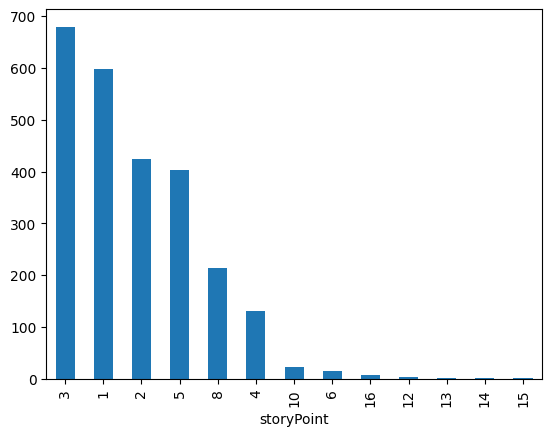

In [4]:
print(dataset['storyPoint'].value_counts())
dataset['storyPoint'].value_counts().plot(kind='bar')

In [5]:
train_dataset, test_dataset = train_test_split(dataset, test_size=0.05, random_state=2024)
train_dataset, _ = train_test_split(train_dataset, test_size=0.80, random_state=2024)

In [6]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 475 entries, 2218 to 2217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   summary     475 non-null    object
 1   storyPoint  475 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 11.1+ KB


In [7]:
test_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 126 entries, 1349 to 1070
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   summary     126 non-null    object
 1   storyPoint  126 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.0+ KB


Tokenizer

In [8]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [9]:
def preprocess_data(row):
    text = row['summary']
    text = str(text)
    text = ' '.join(text.split())

    encodings = tokenizer(text, padding="max_length", truncation=True, max_length=512)

    
    encodings['labels'] = row['storyPoint'] - 1

    return encodings

In [10]:
processed_data = [preprocess_data(row) for _, row in train_dataset.iterrows()]

In [11]:
processed_data[:5]

[{'input_ids': [101, 10651, 1043, 2278, 4654, 8586, 16161, 2099, 2000, 3191, 26520, 5460, 2013, 5472, 8758, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## Generate train and validation dataset

In [12]:
encoded_dataset = pd.DataFrame(processed_data)

train_ds, validation_ds = train_test_split(encoded_dataset, test_size=0.15, random_state=2024)

In [13]:
train_ds.head()

,attention_mask,input_ids,labels,token_type_ids
407,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...","[101, 8081, 2490, 2005, 1030, 18856, 2401, 356...",4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
214,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 2057, 11887, 2135, 4957, 2000, 1037, 310...",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
243,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...","[101, 8556, 20248, 3295, 2128, 1011, 5950, 494...",4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
286,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...","[101, 2191, 1000, 13158, 4708, 1000, 10954, 24...",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
326,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[101, 2490, 7642, 3989, 1013, 4078, 11610, 227...",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [14]:
train_hg = Dataset(pa.Table.from_pandas(train_ds))
valid_hg = Dataset(pa.Table.from_pandas(validation_ds))

In [15]:
train_hg

Dataset({
    features: ['attention_mask', 'input_ids', 'labels', 'token_type_ids', '__index_level_0__'],
    num_rows: 403
})

In [16]:
max_value = train_ds['labels'].max()

print(max_value)

15


## Create a model

If doesn't exist a pretrained model

In [82]:
model = AutoModelForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=16
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


If already have one pretrained

In [17]:
model = AutoModelForSequenceClassification.from_pretrained('./model/').to('cpu')
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

## Training

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [19]:
training_args = TrainingArguments(
    output_dir='./results',          
    num_train_epochs=3,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=64,   
    warmup_steps=500,                
    weight_decay=0.01,               
    logging_dir='./logs',            
    logging_steps=10,                
    evaluation_strategy="epoch",     
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_hg,  # Aquí debes pasar el conjunto de datos de entrenamiento
    eval_dataset=valid_hg,   # Aquí debes pasar el conjunto de datos de validación
    tokenizer=tokenizer
)

c:\Users\franc\anaconda3\envs\pasantia_ia_llm\lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [87]:
trainer.train()

  0%|          | 0/78 [00:00<?, ?it/s]

{'loss': 2.7262, 'grad_norm': 7.165398120880127, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.38}
{'loss': 2.7801, 'grad_norm': 7.112311363220215, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.77}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 2.7083234786987305, 'eval_runtime': 134.8728, 'eval_samples_per_second': 0.534, 'eval_steps_per_second': 0.015, 'epoch': 1.0}
{'loss': 2.7109, 'grad_norm': 9.367171287536621, 'learning_rate': 3e-06, 'epoch': 1.15}
{'loss': 2.5976, 'grad_norm': 7.921934127807617, 'learning_rate': 4.000000000000001e-06, 'epoch': 1.54}
{'loss': 2.4633, 'grad_norm': 6.424463748931885, 'learning_rate': 5e-06, 'epoch': 1.92}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 2.3389034271240234, 'eval_runtime': 135.4474, 'eval_samples_per_second': 0.532, 'eval_steps_per_second': 0.015, 'epoch': 2.0}
{'loss': 2.3598, 'grad_norm': 6.5552215576171875, 'learning_rate': 6e-06, 'epoch': 2.31}
{'loss': 2.239, 'grad_norm': 8.776622772216797, 'learning_rate': 7.000000000000001e-06, 'epoch': 2.69}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 2.099653720855713, 'eval_runtime': 128.3344, 'eval_samples_per_second': 0.561, 'eval_steps_per_second': 0.016, 'epoch': 3.0}
{'train_runtime': 10622.0667, 'train_samples_per_second': 0.114, 'train_steps_per_second': 0.007, 'train_loss': 2.518079170813927, 'epoch': 3.0}


TrainOutput(global_step=78, training_loss=2.518079170813927, metrics={'train_runtime': 10622.0667, 'train_samples_per_second': 0.114, 'train_steps_per_second': 0.007, 'train_loss': 2.518079170813927, 'epoch': 3.0})

## Evaluating

In [38]:
metrics = trainer.evaluate()

  0%|          | 0/2 [00:00<?, ?it/s]

In [42]:
metrics_ds = pd.DataFrame.from_records([metrics])
metrics_ds.to_csv('./outputs/metrics.csv', index=False)

metrics_ds


,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second
0,2.099654,208.1892,0.346,0.01


## Save the model

In [89]:
model.save_pretrained('./model/')

## Predicting

In [20]:
def get_predictions(texts):
    story_points = []
    probabilities = []

    for text in texts:
        encoding = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=512)
        encoding = {k: v.to(trainer.model.device) for k,v in encoding.items()}

        outputs = model(**encoding)

        logits = outputs.logits
        sigmoid = torch.nn.Sigmoid()

        probs = sigmoid(logits.squeeze().cpu())
        probs = probs.detach().numpy()
        label = np.argmax(probs, axis=-1)

        story_points.append(label + 1)
        probabilities.append(probs)

    return pd.DataFrame({'summary': texts, 'story point': story_points, 'probability': probabilities})

In [21]:
example = test_dataset.head(10)
predictions = get_predictions(example['summary'].tolist())
predictions

,summary,story point,probability
0,Make Batch Job Restarts Work using Single Node,3,"[0.78743964, 0.6852064, 0.8126309, 0.6070777, ..."
1,Improve NotificationsService test coverage,3,"[0.77024025, 0.72019523, 0.8012384, 0.588902, ..."
2,Admin app crashes with SSL certification errors,1,"[0.7839334, 0.64887804, 0.7795144, 0.5949048, ..."
3,Ensure that branch-specific documentation is p...,3,"[0.77222604, 0.7182167, 0.7898201, 0.5884438, ..."
4,Look into broken tests and open tickets,3,"[0.7567187, 0.7077529, 0.7735129, 0.58235264, ..."
5,Backport metadata retrieval stability improvem...,3,"[0.7505117, 0.69268215, 0.7884136, 0.5879194, ..."
6,Upgrade to SHDP GA Release,3,"[0.7797716, 0.68887675, 0.7938025, 0.5884383, ..."
7,Submit java receptor client for CF incubation,3,"[0.7905003, 0.6738088, 0.79280674, 0.57734597,..."
8,stack overflow when trying to create a stream ...,3,"[0.78379774, 0.66356874, 0.79646885, 0.6125790..."
9,Could not override rabbit sink module's rabbit...,3,"[0.78831446, 0.6630695, 0.8041137, 0.6265029, ..."


In [22]:
example

,summary,storyPoint
1349,Make Batch Job Restarts Work using Single Node,3
1188,Improve NotificationsService test coverage,3
328,Admin app crashes with SSL certification errors,8
936,Ensure that branch-specific documentation is p...,12
1345,Look into broken tests and open tickets,5
380,Backport metadata retrieval stability improvem...,8
2361,Upgrade to SHDP GA Release,3
1949,Submit java receptor client for CF incubation,3
1916,stack overflow when trying to create a stream ...,3
535,Could not override rabbit sink module's rabbit...,4


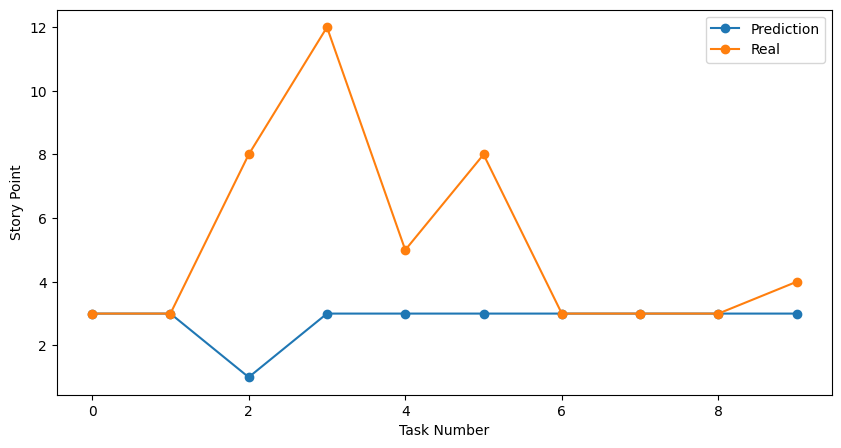

In [23]:
x = list(range(len(predictions)))

plt.figure(figsize=(10, 5))

plt.plot(x, predictions['story point'].tolist(), label='Prediction', marker='o')

plt.plot(x, example['storyPoint'], label='Real', marker='o')

plt.xlabel('Task Number') 
plt.ylabel('Story Point')

plt.legend()

plt.show()

In [36]:
plt.savefig('./outputs/predictions_vs_real.png')

<Figure size 640x480 with 0 Axes>

In [37]:
predictions = predictions['story point'].tolist()
real_values = example['storyPoint']

results = pd.DataFrame({
    'Predictions': predictions,
    'Real Values': real_values
})

results.to_csv('./outputs/predictions_and_real_values.csv', index=False)

In [38]:
example.to_csv('./outputs/example.csv', index=False)

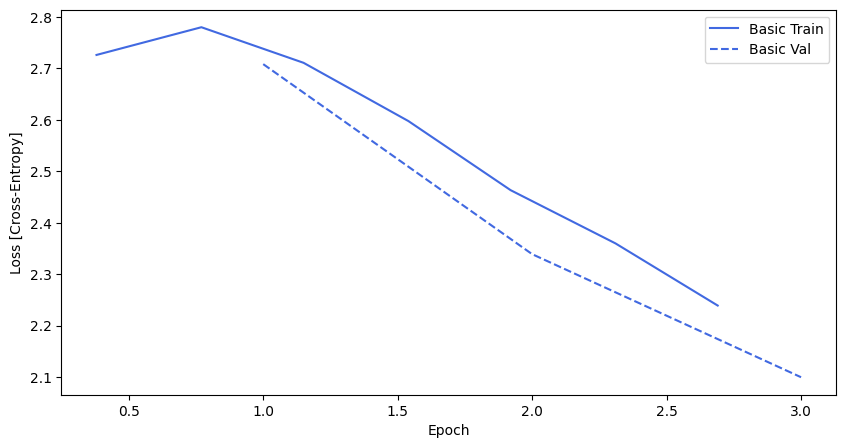

In [13]:
df = pd.read_csv("C:/Users/franc/Downloads/history.csv")
df2 = pd.read_csv("C:/Users/franc/Downloads/history_validation_llm.csv")

plt.figure(figsize=(10, 5))

plt.plot(df['epoch'], df['loss'], color='royalblue', label='Basic Train')
plt.plot(df2['epoch'], df2['eval_loss'], '--', color='royalblue', label='Basic Val')

plt.xlabel('Epoch') 
plt.ylabel('Loss [Cross-Entropy]')

plt.legend()

plt.show()